# Customer-churn-model

The case study consists of calculating the churn of customers in a telecommunications company. 

The company has found that between December 2019 and January 2020 they have had quite a few customer casualties.

The objective is to build an analytical model that is capable of predicting the next customers who are potential to leave the operator in order to launch a campaign and try to retain them before portability.

In addition, company managers want to know the reasons why customers are leaving. 

For this we have several datasets with data that provide customer information.

In [392]:
# Import libraries

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from dateutil.rrule import rrule, MONTHLY
import pickle #Python objects are stored in these libraries

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression 
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import StandardScaler



## 1) Loading data and building data tables

In [393]:
#### Data upload (December 2019)
december_clients = pd.read_csv("clientes_diciembre.csv", sep='|')
december_consumption = pd.read_csv("consumos_diciembre.csv", sep='|')
december_financing = pd.read_csv("financiacion_diciembre.csv", sep='|')
december_products = pd.read_csv("productos_diciembre.csv", sep='|')

In [394]:
#data visualization and data exploration
december_clients.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN


In [395]:
december_consumption.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,110,79,10897,12806,13751
1,2,189,89,18657,6499,10862
2,3,129,30,15511,17013,16743
3,4,51,52,12670,3393,6771
4,5,183,3,23756,18436,4485


In [396]:
december_financing.head()

,id,financiacion,imp_financ,descuentos
0,2,NaN,NaN,SI
1,3,NaN,NaN,SI
2,7,SI,31.553269,NaN
3,11,NaN,NaN,SI
4,12,NaN,NaN,SI


In [397]:
december_products.head()

,id,conexion,vel_conexion,TV
0,1,FIBRA,50MB,tv-futbol
1,2,FIBRA,600MB,tv-futbol
2,3,ADSL,35MB,tv-futbol
3,4,FIBRA,200MB,tv-familiar
4,5,ADSL,10MB,tv-futbol


In [398]:
december_clients.shape

(95467, 8)

In [399]:
december_consumption.shape

(95467, 6)

In [400]:
december_financing.shape #This dataset has less data (rows)

(24198, 4)

In [401]:
december_products.shape

(95467, 4)

### Table creation with all the data for the month of December
We are going to join the three datasets that correspond to the month of December 2019, to have all the information together, and be able to work later.

In [402]:
december_clients_consumption = pd.merge(december_clients, december_consumption, on='id')

#december_clients_consumption.head()

#december_clients_consumption.shape  -> (95467, 13)

In [403]:
december_clients_consumption_products = pd.merge(december_clients_consumption,december_products, on='id')

#december_clients_consumption_products.shape  -> (95467, 16)

In [404]:
december_data = pd.merge(december_clients_consumption_products,december_financing, how='left',on='id', )

#We check that we have the same number of rows as at the beginning in the customer datafreme and that we have the correct number of columns.
#datos_diciembre.shape  -> (95467, 19)

In [405]:
december_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,ADSL,10MB,tv-futbol,NaN,NaN,NaN


#### Data upload (January 2020)
We do the same as with the December data.

In [406]:
january_clients = pd.read_csv("clientes_enero.csv", sep='|')
january_consumption = pd.read_csv("consumos_enero.csv", sep='|')
january_financing = pd.read_csv("financiacion_enero.csv", sep='|')
january_products = pd.read_csv("productos_enero.csv", sep='|')

In [407]:
january_clients.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN


In [408]:
january_consumption.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,95,19,6525,7634,18520
1,2,44,36,14471,14541,8016
2,3,94,27,1428,5248,7106
3,4,186,20,20083,7372,5052
4,6,37,32,19078,5009,8686


In [409]:
january_financing.head()

,id,financiacion,imp_financ,descuentos
0,2,NaN,NaN,SI
1,3,NaN,NaN,SI
2,7,SI,31.553269,NaN
3,11,NaN,NaN,SI
4,12,NaN,NaN,SI


In [410]:
january_clients.shape

(92711, 8)

In [411]:
january_consumption.shape

(92711, 6)

In [412]:
january_financing.shape

(25332, 4)

In [413]:
january_products.shape

(92711, 4)

### Table creation with all the data for the month of January

In [414]:
january_clients_consumption = pd.merge(january_clients,january_consumption, on='id')

#january_clients_consumption.head()

#january_clients_consumption.shape -> (92711, 13)

In [415]:
january_clients_consumption_products = pd.merge(january_clients_consumption,january_products, on='id')

#january_clients_consumption_products.head()

#january_clients_consumption_products.shape -> (92711, 16)

In [416]:
january_data = pd.merge(january_clients_consumption_products,january_financing, how='left',on='id', )

#january_data.shape -> (92711, 19)

In [417]:
january_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,95,19,6525,7634,18520,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,44,36,14471,14541,8016,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,94,27,1428,5248,7106,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,186,20,20083,7372,5052,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,37,32,19078,5009,8686,FIBRA,200MB,tv-futbol,NaN,NaN,NaN


### Creation of target variable
My variable should tell me the retained customers: those who were in December and are still in January.

Finally we have to get 0 = customer retained, 1 = customer churn.

In [418]:
#I want to know the customers who were in December and still in January
data_retained = pd.merge(january_data,december_data, on = 'id')
data_retained # these clients are the ones in the company in January, the rest has churn.

,id,edad_x,facturacion_x,antiguedad_x,provincia_x,num_lineas_x,num_dt_x,incidencia_x,num_llamad_ent_x,num_llamad_sal_x,...,num_llamad_sal_y,mb_datos_y,seg_llamad_ent_y,seg_llamad_sal_y,conexion_y,vel_conexion_y,TV_y,financiacion_y,imp_financ_y,descuentos_y
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,95,19,...,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,44,36,...,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,94,27,...,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,186,20,...,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,37,32,...,51,18428,8956,4764,FIBRA,200MB,tv-futbol,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88377,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,42,17,...,98,13403,6197,6853,ADSL,35MB,tv-familiar,SI,23.138779,NaN
88378,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,217,96,...,13,5291,3684,1667,ADSL,30MB,tv-futbol,NaN,NaN,NaN
88379,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,168,99,...,20,20002,572,5679,FIBRA,200MB,tv-futbol,SI,14.616422,NaN
88380,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,188,71,...,26,16448,833,14398,ADSL,20MB,tv-futbol,NaN,NaN,NaN


In [419]:
id_retained = data_retained['id']
#convert to dataframe
id_retained2 = pd.DataFrame(id_retained, columns = ['id'])
id_retained2

,id
0,1
1,2
2,3
3,4
4,6
...,...
88377,99995
88378,99996
88379,99997
88380,99998


In [420]:
#add column
id_retained2.insert(1,'y_clients', '0') 

# If 'y_clients' is 0 it is because they are the ones who continue in the company. I am interested in (success = 1) those who leave.
# Then I am going to add the column "y_clients" to the December dataset, the clients that are NA will be 1 (success, they had churn).

In [421]:
december_data = pd.merge(december_data, id_retained2,on='id',how='left') 
december_data

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_clients
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,0
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI,0
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI,0
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,0
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,ADSL,10MB,tv-futbol,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95462,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,121,98,13403,6197,6853,ADSL,35MB,tv-familiar,SI,23.138779,NaN,0
95463,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,98,13,5291,3684,1667,ADSL,30MB,tv-futbol,NaN,NaN,NaN,0
95464,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,226,20,20002,572,5679,FIBRA,200MB,tv-futbol,SI,14.616422,NaN,0
95465,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,126,26,16448,833,14398,ADSL,20MB,tv-futbol,NaN,NaN,NaN,0


In [422]:
december_data.isnull().sum() 
# We can see that 7085 customers has churn between December 2019 and January 2020

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      89095
imp_financ        89095
descuentos        76313
y_clients          7085
dtype: int64

### 2) Data pre-processing and cleaning
I will only work transforming my variables to numeric, not to dummy variables.

** I know there are ways to do this process more efficiently, either by creating a list of numerical and categorical variables to apply joint modifications. However, I preferred to do it manually due to how required to present the analysis.

#### Missing values analysis (December)

In [423]:
december_data.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      89095
imp_financ        89095
descuentos        76313
y_clients          7085
dtype: int64

We see that we have to do something with 6 variables that have missing values

In [424]:
#1) 'num_dt' They are the lines that are unpaid, if they are blank we will complete them with a 0.
december_data['num_dt'] = december_data['num_dt'].replace(np.nan, 0)

In [425]:
#2) 'incidencia' If it is blank, it is because the client has no incidence
december_data['incidencia'] = december_data['incidencia'].replace(np.nan, 'NO')

In [426]:
#3) 'financiacion' If it is blank, then the client doen't have any financing
december_data['financiacion'] = december_data['financiacion'].replace(np.nan, 'NO')

In [427]:
#4) 'imp_financ' If it is blank, then the client doen't have any financing and therefore they do not have any financed amount
december_data['imp_financ'] = december_data['imp_financ'].replace(np.nan, 0)

In [428]:
#5) 'descuentos ' If it is blank it is because the client does not have any type of discount.
december_data['descuentos'] = december_data['descuentos'].replace(np.nan, 0)

In [429]:
#6) 'y_clients ' If it is blank, it is because the client has churn between one month and another.
december_data['y_clients'] = december_data['y_clients'].replace(np.nan, 1)
december_data['y_clients'] = december_data['y_clients'].astype(int)

In [430]:
# We check that we have no NA
december_data.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
financiacion      0
imp_financ        0
descuentos        0
y_clients         0
dtype: int64

#### --- Numerical variables analysis --- (December)

In [431]:
# Type of data
december_data.dtypes # 12 numerical variables

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
financiacion       object
imp_financ        float64
descuentos         object
y_clients           int64
dtype: object

In [432]:
december_data.describe() # -> everything seems fine

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ,y_clients
count,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000
mean,49994.256832,51.462086,207.392912,3.558518,0.170530,124.815633,50.022762,12489.795898,9984.406612,10029.761342,1.486331,0.074214
std,28873.008865,19.590846,111.343491,1.086095,0.694799,72.492338,29.119904,7239.421267,5763.182070,5763.518604,6.148373,0.262120
min,1.000000,18.000000,15.000439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24997.500000,35.000000,111.383822,3.000000,0.000000,62.000000,25.000000,6177.500000,5006.000000,5055.000000,0.000000,0.000000
50%,49970.000000,51.000000,206.808431,4.000000,0.000000,124.000000,50.000000,12466.000000,9965.000000,10024.000000,0.000000,0.000000
75%,75021.500000,68.000000,304.436599,4.000000,0.000000,188.000000,75.000000,18785.500000,14969.000000,15007.000000,0.000000,0.000000
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.990128,1.000000


In [433]:
# We check that we do not have repeated IDs
december_data['id'].value_counts() 

2047     1
76464    1
27288    1
25241    1
31386    1
        ..
54640    1
56689    1
50546    1
52595    1
2049     1
Name: id, Length: 95467, dtype: int64

#### --- non-numeric variables analysis --- (December)

antiguedad, provincia, incidencia, conexion, vel_conexion, TV, financiacion, descuentos

1) ANTIGUEDAD

In [434]:
december_data['antiguedad'].value_counts() 
# We see that some dates are repeated twice

11/09/2013 10:46 AM    2
11/03/2008 05:28 PM    2
01/05/2005 05:08 AM    2
01/10/2006 03:18 AM    2
09/01/1999 11:19 AM    2
                      ..
05/04/2005 09:20 AM    1
01/05/2000 08:42 PM    1
02/11/1998 05:18 PM    1
09/08/2000 12:48 PM    1
12/03/2019 06:52 AM    1
Name: antiguedad, Length: 95171, dtype: int64

In [435]:
# We change the date to datetime format:
december_data['antiguedad'] = pd.to_datetime(december_data['antiguedad'])

We create a new variable that tells me the client's age in years

In [436]:
# Creation of a column that contains the year of entry to the company to later calculate its age in yearsdatos_diciembre['año_ingreso'] = pd.DatetimeIndex(datos_diciembre['antiguedad']).year
december_data['año_ingreso'] = pd.DatetimeIndex(december_data['antiguedad']).year
december_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_clients,año_ingreso
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,110,79,...,12806,13751,FIBRA,50MB,tv-futbol,NO,0.0,0,0,2018
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,189,89,...,6499,10862,FIBRA,600MB,tv-futbol,NO,0.0,SI,0,2017
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,129,30,...,17013,16743,ADSL,35MB,tv-futbol,NO,0.0,SI,0,2001
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,51,52,...,3393,6771,FIBRA,200MB,tv-familiar,NO,0.0,0,0,2015
4,5,25,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NO,183,3,...,18436,4485,ADSL,10MB,tv-futbol,NO,0.0,0,1,1997


In [437]:
# Creation of variable that tells me the age in years
december_data['antiguedad_años'] = 2019 - december_data['año_ingreso']
december_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_clients,año_ingreso,antiguedad_años
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,110,79,...,13751,FIBRA,50MB,tv-futbol,NO,0.0,0,0,2018,1
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,189,89,...,10862,FIBRA,600MB,tv-futbol,NO,0.0,SI,0,2017,2
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,129,30,...,16743,ADSL,35MB,tv-futbol,NO,0.0,SI,0,2001,18
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,51,52,...,6771,FIBRA,200MB,tv-familiar,NO,0.0,0,0,2015,4
4,5,25,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NO,183,3,...,4485,ADSL,10MB,tv-futbol,NO,0.0,0,1,1997,22


In [438]:
december_data['antiguedad_años'].value_counts() 

13    3958
20    3903
19    3886
9     3857
15    3851
5     3850
16    3847
12    3843
8     3838
10    3834
14    3831
22    3825
11    3824
24    3818
0     3809
1     3798
7     3793
23    3792
6     3786
4     3775
21    3774
3     3770
17    3758
18    3743
2     3704
Name: antiguedad_años, dtype: int64

In [439]:
december_data.drop('año_ingreso',axis=1, inplace=True)

In [440]:
december_data.drop('antiguedad',axis=1, inplace=True)

2) PROVINCIA

In [441]:
len(december_data['provincia'].unique())

50

In [442]:
december_data['provincia'].value_counts() 

Zaragoza                  1991
Navarra                   1986
Málaga                    1973
Valencia                  1972
Asturias                  1972
Murcia                    1967
Orense                    1958
Alicante                  1954
Córdoba                   1949
Cáceres                   1945
Burgos                    1939
Guipúzcoa                 1936
Álava                     1932
Valladolid                1931
Sevilla                   1928
Huelva                    1924
Santa Cruz de Tenerife    1922
La Coruña                 1921
Segovia                   1917
Castellón                 1915
Granada                   1914
Zamora                    1913
Tarragona                 1913
Almería                   1912
Soria                     1909
Pontevedra                1907
Madrid                    1907
Ciudad Real               1905
Cádiz                     1902
Badajoz                   1900
Barcelona                 1899
Islas Baleares            1899
Salamanc

In [443]:
#We could have done this with a Label Encode, but personally I preferred to do it manually
december_data.provincia.replace(('Zaragoza','Navarra','Málaga','Asturias','Valencia',
                                   'Murcia','Orense','Alicante','Córdoba','Cáceres',
                                   'Burgos','Guipúzcoa','Álava','Valladolid','Sevilla',
                                   'Huelva', 'Santa Cruz de Tenerife', 'La Coruña', 'Segovia','Castellón',
                                   'Granada','Tarragona','Zamora','Almería','Soria',
                                   'Madrid','Pontevedra','Ciudad Real','Cádiz','Badajoz',
                                   'Islas Baleares','Barcelona','Teruel','Salamanca','Ávila',
                                   'Albacete','Jaén','Guadalajara','Lérida','La Rioja',
                                   'Lugo','Toledo','Gerona','Las Palmas','Palencia',
                                   'Cuenca','Cantabria','León','Vizcaya','Huesca'
                                   ),
                                  (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                  21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                                  38,39,40,41,42,43,44,45,46,47,48,49,50),inplace=True)

3) INCIDENCIA

In [444]:
december_data['incidencia'].value_counts()

NO    90235
SI     5232
Name: incidencia, dtype: int64

In [445]:
december_data['incidencia'] = december_data['incidencia'].map({'SI':1,'NO':0})

In [446]:
december_data['incidencia'].value_counts()

0    90235
1     5232
Name: incidencia, dtype: int64

4) CONEXIÓN

In [447]:
december_data['conexion'].value_counts()

ADSL     47900
FIBRA    47567
Name: conexion, dtype: int64

In [448]:
#ADSL = 1, FIBRA = 0
december_data['conexion'] = december_data['conexion'].map({'ADSL':1,'FIBRA':0})

In [449]:
december_data['conexion'].value_counts()

1    47900
0    47567
Name: conexion, dtype: int64

5) VELOCIDAD

In [450]:
december_data['vel_conexion'].value_counts()

200MB    9677
600MB    9623
50MB     9474
300MB    9461
100MB    9332
20MB     8113
25MB     8112
10MB     7970
30MB     7948
35MB     7947
15MB     7810
Name: vel_conexion, dtype: int64

In [451]:
# Creation of a function to leave only the numbers
def dejar_solo_cifras(txt):
  return "".join(c for c in txt if c.isdigit())

In [452]:
december_data.vel_conexion = december_data.vel_conexion.map(dejar_solo_cifras)

In [453]:
december_data['vel_conexion'].value_counts()

200    9677
600    9623
50     9474
300    9461
100    9332
20     8113
25     8112
10     7970
30     7948
35     7947
15     7810
Name: vel_conexion, dtype: int64

In [454]:
december_data['vel_conexion'] = december_data['vel_conexion'].astype(int)

6) TV

In [455]:
december_data['TV'].value_counts()

tv-futbol      47535
tv-familiar    33768
tv-total       14164
Name: TV, dtype: int64

In [456]:
#tv-futbol:0, tv-familiar:1, tv-total:2
december_data['TV'] = december_data['TV'].map({'tv-futbol':0,'tv-familiar':1, 'tv-total':2})

In [457]:
december_data['TV'].value_counts()

0    47535
1    33768
2    14164
Name: TV, dtype: int64

7) FINANCIACIÓN

In [458]:
december_data['financiacion'].value_counts()

NO    89095
SI     6372
Name: financiacion, dtype: int64

In [459]:
december_data['financiacion'] = december_data['financiacion'].map({'SI':1,'NO':0})

In [460]:
december_data['financiacion'].value_counts()

0    89095
1     6372
Name: financiacion, dtype: int64

8) DESCUENTOS

In [461]:
december_data['descuentos'].value_counts()

0     76313
SI    19154
Name: descuentos, dtype: int64

In [462]:
december_data['descuentos'] = december_data['descuentos'].map({'SI':1,0:0})

In [463]:
december_data['descuentos'].value_counts()

0    76313
1    19154
Name: descuentos, dtype: int64

In [464]:
#We check that everything is numeric
december_data.dtypes

id                   int64
edad                 int64
facturacion        float64
provincia            int64
num_lineas           int64
num_dt             float64
incidencia           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion             int64
vel_conexion         int64
TV                   int64
financiacion         int64
imp_financ         float64
descuentos           int64
y_clients            int64
antiguedad_años      int64
dtype: object

#### Correlation analysis

In [465]:
corr =  abs(december_data.corr())
corr[['y_clients']].sort_values(by = 'y_clients',ascending = False).style.background_gradient()

,y_clients
y_clients,1.000000
num_dt,0.504867
incidencia,0.500885
descuentos,0.141447
financiacion,0.074597
imp_financ,0.067626
num_llamad_ent,0.006130
TV,0.004284
antiguedad_años,0.003310
num_llamad_sal,0.003141


Based on the relationship between the variables and my target we can see that there are two highly correlated variables ('num_dt' and 'incidence') and then we have two more variables that seem important.

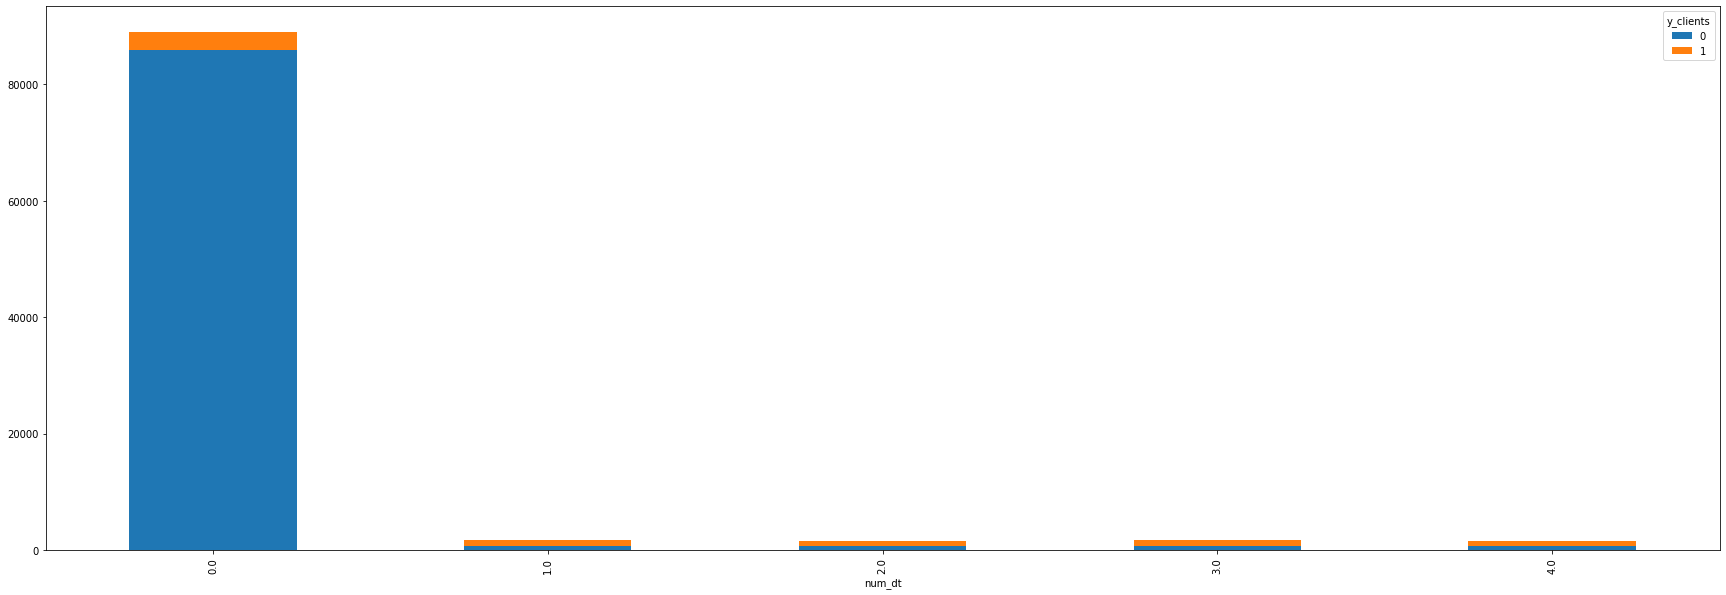

In [466]:
december_data.groupby(["num_dt", "y_clients"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

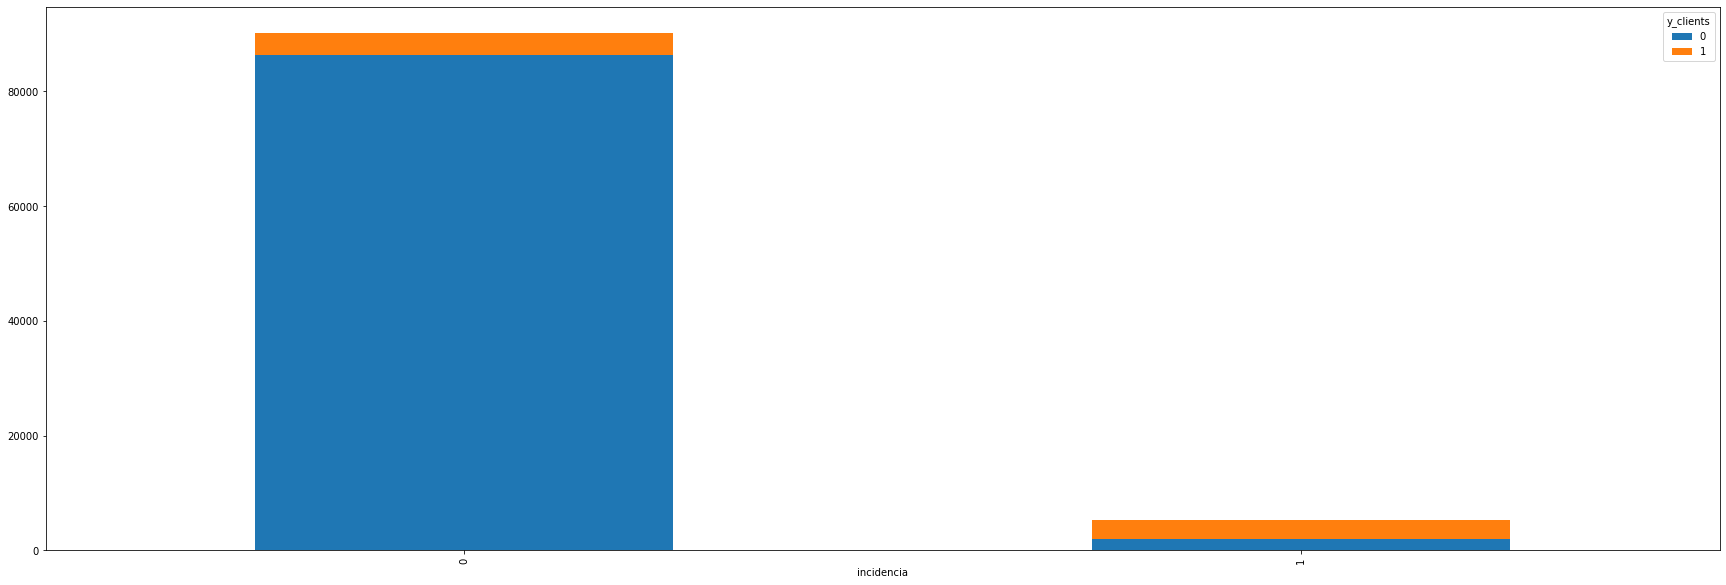

In [467]:
december_data.groupby(["incidencia", "y_clients"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

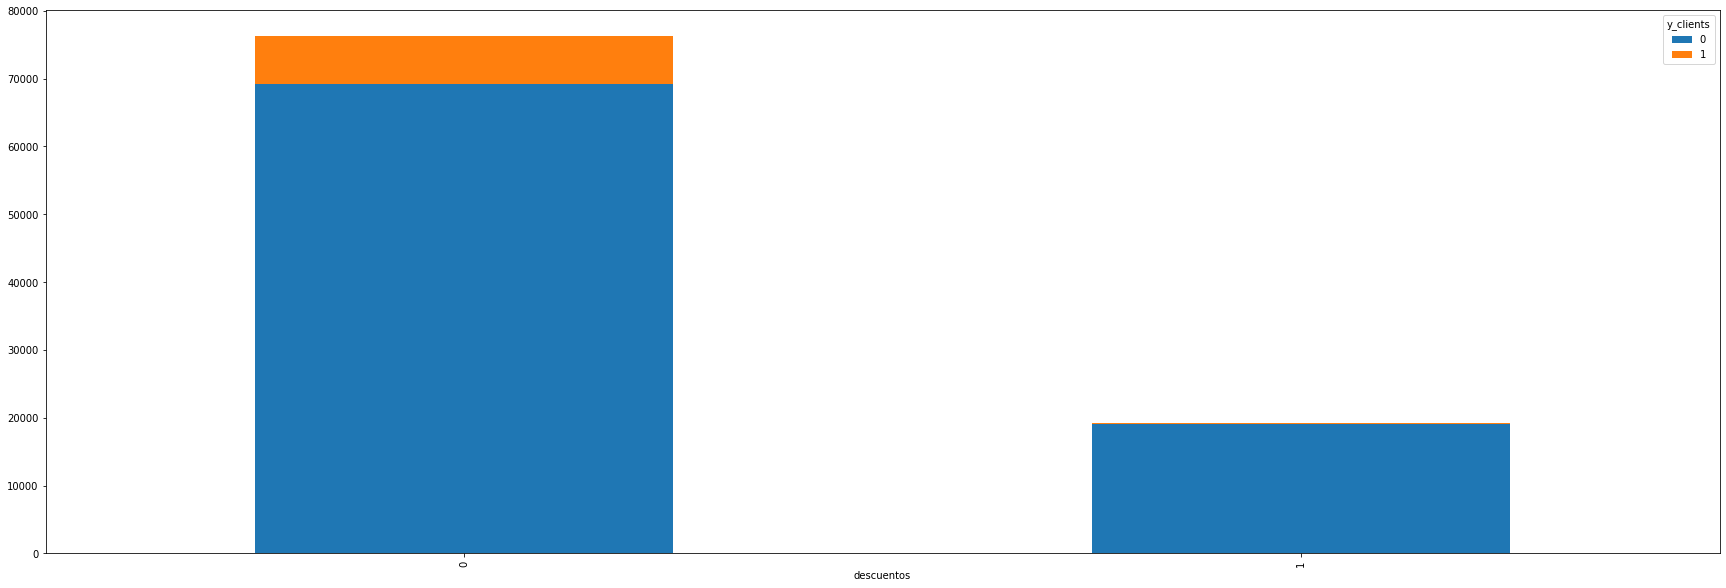

In [468]:
december_data.groupby(["descuentos", "y_clients"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

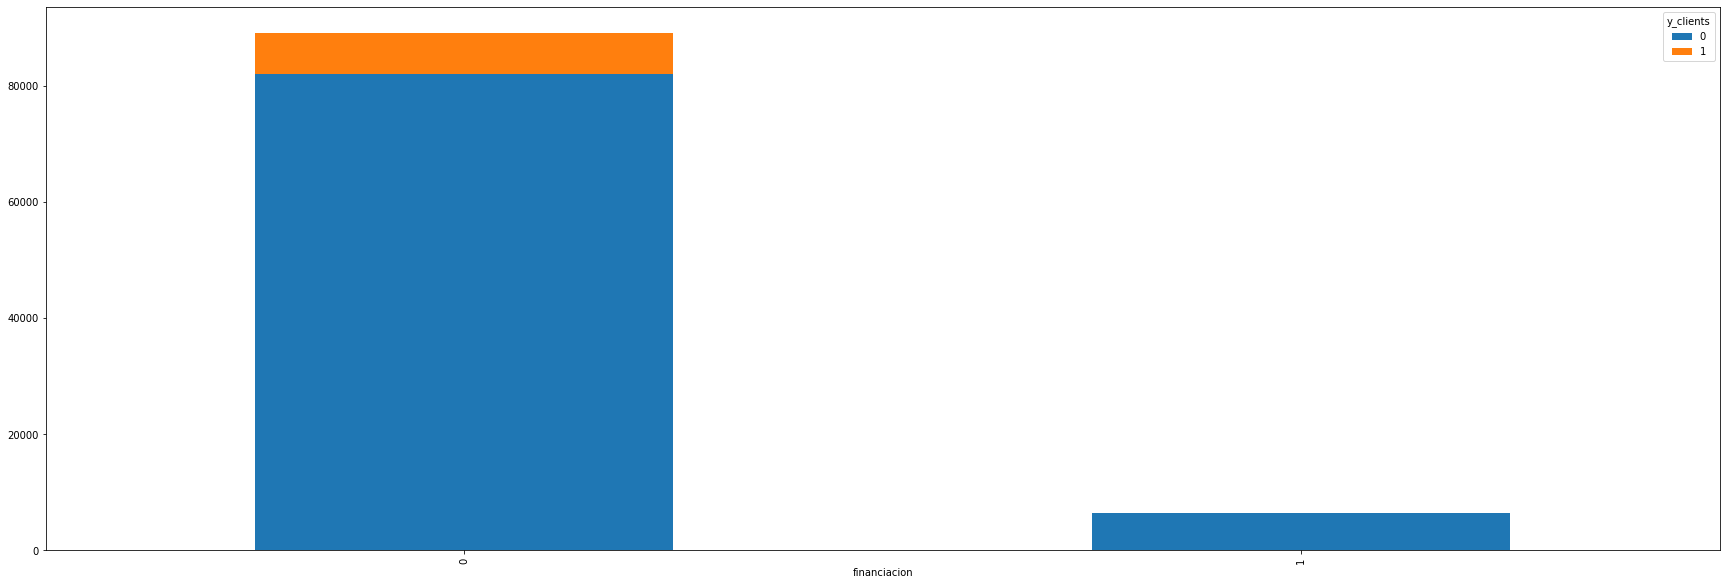

In [469]:
december_data.groupby(["financiacion", "y_clients"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

In [470]:
december_data.set_index('id',inplace=True)

### 3) Stratified random sampling 

We need to stratify so that the train and test variables have the same proportion of customers that has churn and customers that stay as the original variable.

In [471]:
#I get my data without the target
data = december_data.copy(deep = True)
data.drop('y_clients',axis=1, inplace=True)

In [472]:
y_december = december_data[['y_clients']]

In [473]:
data.shape

(95467, 18)

In [474]:
y_december.shape

(95467, 1)

In [475]:
y_december['y_clients'].value_counts()

0    88382
1     7085
Name: y_clients, dtype: int64

In [476]:
# We see the variance of the data
np.var(data) 

edad               3.837972e+02
facturacion        1.239724e+04
provincia          2.083071e+02
num_lineas         1.179589e+00
num_dt             4.827403e-01
incidencia         5.180077e-02
num_llamad_ent     5.255084e+03
num_llamad_sal     8.479599e+02
mb_datos           5.240867e+07
seg_llamad_ent     3.321392e+07
seg_llamad_sal     3.321780e+07
conexion           2.499970e-01
vel_conexion       3.214092e+04
TV                 5.240972e-01
financiacion       6.229060e-02
imp_financ         3.780210e+01
descuentos         1.603805e-01
antiguedad_años    5.176277e+01
dtype: float64

In [477]:
## Variable scaling:
# Let's do it since we have data that moves between ranges of small values, and others have much larger values.
sc = StandardScaler()
data_scaler = sc.fit_transform(data)

In [478]:
X_train, X_test, y_train, y_test = train_test_split(data_scaler,
                                                    y_december,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_december)

In [479]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)  

### 4) Model
We have to use some classification model, since we need to know the probability that something happens or not. In this case, it is that the client leaves the company (1) or stays (0) from one month to another.

Therefore, we are going to work with two types of models to see which is the best for this study (Logistic Regression and Random Forest)

### We make our first models with all the variables

In [480]:
model_log_1 = LogisticRegression().fit(X_train, y_train)
y_pred_log_1 = model_log_1.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17400   277]
 [  200  1217]]
accuracy
0.9750183303655598
precision
0.8145917001338688
recall
0.8588567395906845
f1
0.8361387839230505
AUC
0.9215933299130094


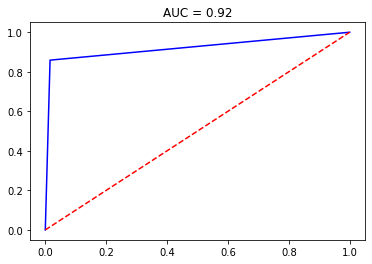

In [481]:
saca_metricas(y_test, y_pred_log_1)   

Feature: 0, Score: 0.01357
Feature: 1, Score: 0.03725
Feature: 2, Score: 0.01761
Feature: 3, Score: 0.03156
Feature: 4, Score: 1.62492
Feature: 5, Score: 1.32121
Feature: 6, Score: 0.03120
Feature: 7, Score: -0.01058
Feature: 8, Score: 0.03716
Feature: 9, Score: 0.01318
Feature: 10, Score: -0.01604
Feature: 11, Score: 0.01608
Feature: 12, Score: 0.04607
Feature: 13, Score: -0.00826
Feature: 14, Score: -1.59902
Feature: 15, Score: -0.68526
Feature: 16, Score: -4.75090
Feature: 17, Score: 0.00783


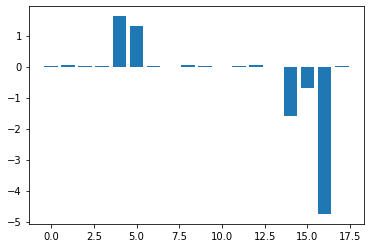

In [482]:
# get importance
importance = model_log_1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [483]:
data.columns.values

array(['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'conexion', 'vel_conexion',
       'TV', 'financiacion', 'imp_financ', 'descuentos',
       'antiguedad_años'], dtype=object)

Within the importance of the variables, we are interested in those with a positive coefficient.

In this case we see that there are two quite important variables: 'num_dt' and 'incidence'.

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17367   310]
 [    9  1408]]
accuracy
0.9832931811040118
precision
0.819557625145518
recall
0.9936485532815809
f1
0.8982456140350877
AUC
0.988055820454786


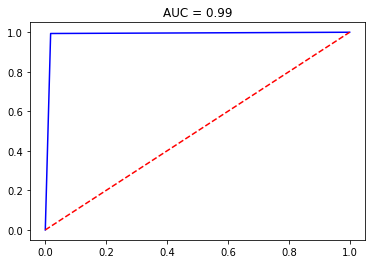

In [484]:
rf_classifier1 = RandomForestClassifier().fit(X_train, y_train)
y_pred1        = rf_classifier1.predict(X_test)
saca_metricas(y_test, y_pred1)

Feature: 0, Score: 0.01795
Feature: 1, Score: 0.02349
Feature: 2, Score: 0.01765
Feature: 3, Score: 0.00743
Feature: 4, Score: 0.37684
Feature: 5, Score: 0.30106
Feature: 6, Score: 0.02164
Feature: 7, Score: 0.01950
Feature: 8, Score: 0.02289
Feature: 9, Score: 0.02238
Feature: 10, Score: 0.02359
Feature: 11, Score: 0.00208
Feature: 12, Score: 0.01083
Feature: 13, Score: 0.00464
Feature: 14, Score: 0.01192
Feature: 15, Score: 0.01256
Feature: 16, Score: 0.08816
Feature: 17, Score: 0.01538


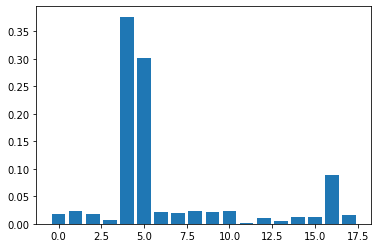

In [485]:
importance = rf_classifier1.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Summary so far:
Both models, to be the first, are quite good. The second is better, not only because the accurancy is higher, but because the variation between it and the recall is less. Also, the precision is a bit better.

### 5) Model improvement

#### Feature Engineering

In [486]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%y_cliente'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%y_cliente']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%y_cliente'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    
   

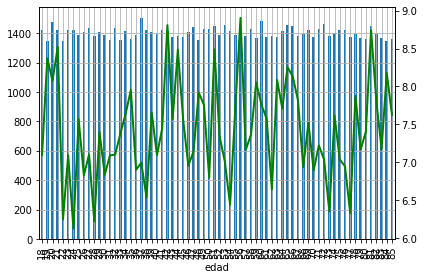

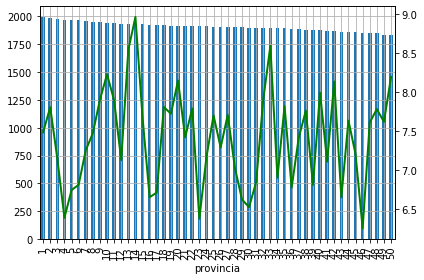

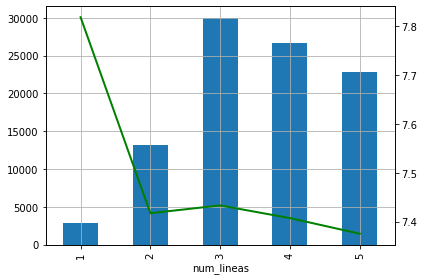

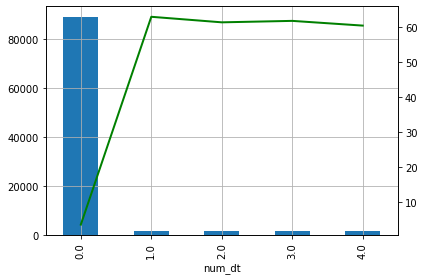

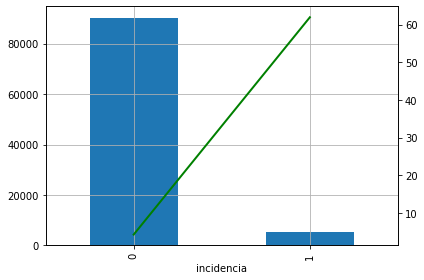

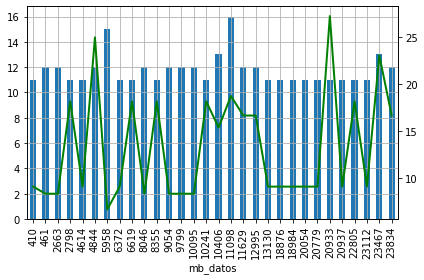

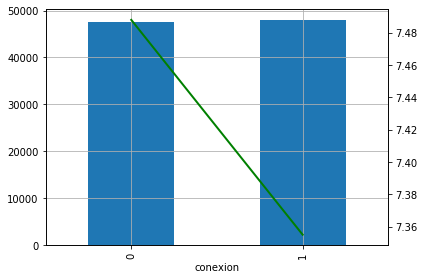

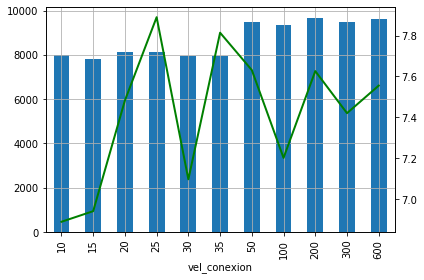

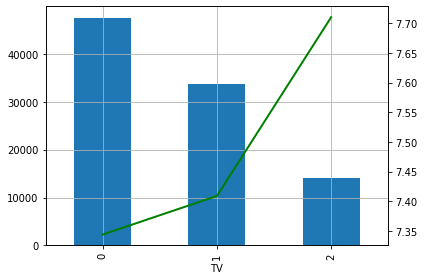

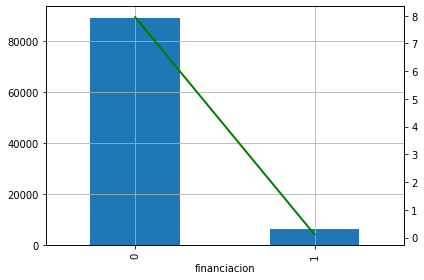

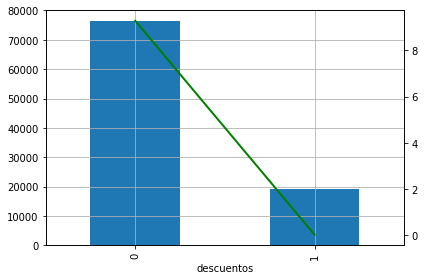

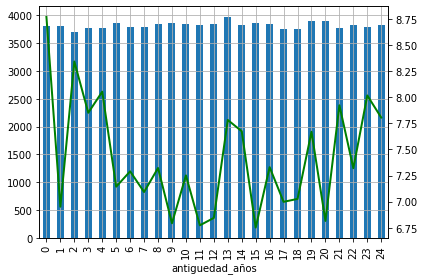

In [487]:
for i in december_data.columns:
    proporciones_final (i, 'y_clients', december_data)


In [488]:
december_data['num_dt_nueva'] = december_data['num_dt'].apply(lambda x: 0 if x<=1 else 1)

In [489]:
## NUM_LINEAS (we make a variable with 3 ranges of number of lines and 3 variables with those same ranges)
december_data['num_lineas_bajo'] = december_data['num_lineas'].apply(lambda x: 1 if x<=2 else 0)
december_data['num_lineas_medio'] = december_data['num_lineas'].apply(lambda x: 1 if x>2 & x<5 else 0)
december_data['num_lineas_alto'] = december_data['num_lineas'].apply(lambda x: 1 if x>=5 else 0)
december_data['num_lineas_nueva'] = december_data['num_lineas'].apply(lambda x: 0 if x<=2 else (1 if x>2 and x<5 else(2)))  

In [490]:
## ANTIGUEDAD_AÑOS (we make a variable with 3 age ranges and 3 variables with those same ranges)
december_data['antiguedad_años_bajo'] = december_data['antiguedad_años'].apply(lambda x: 1 if x<=8 else 0)
december_data['antiguedad_años_medio'] = december_data['antiguedad_años'].apply(lambda x: 1 if x>8 & x<16 else 0)
december_data['antiguedad_años_alto'] = december_data['antiguedad_años'].apply(lambda x: 1 if x>=16 else 0)
december_data['antiguedad_años_nueva'] = december_data['antiguedad_años'].apply(lambda x: 0 if x<=8 else (1 if x>8 and x<16 else(2)))  

In [491]:
## EDAD (we made a variable with 3 age ranges), the data ranges from 18 to 85 years. We are going to do 3 groups
december_data['edad_bajo'] = december_data['edad'].apply(lambda x: 1 if x<=40 else 0)
december_data['edad_medio'] = december_data['edad'].apply(lambda x: 1 if x>40 & x<62 else 0)
december_data['edad_alto'] = december_data['edad'].apply(lambda x: 1 if x>=62 else 0)

In [492]:
corr =  abs(december_data.corr())
corr[['y_clients']].sort_values(by = 'y_clients',ascending = False).style.background_gradient()

,y_clients
y_clients,1.000000
num_dt,0.504867
incidencia,0.500885
num_dt_nueva,0.475903
descuentos,0.141447
financiacion,0.074597
imp_financ,0.067626
antiguedad_años_medio,0.006991
antiguedad_años_bajo,0.006303
num_llamad_ent,0.006130


It is observed that our most important variables remain the same. However, we see that some variables such as 'antiguedad' and 'edad' with the new transformations have improved their correlation and have become more important than before.

In [493]:
# We test a new model with these transformations
december_data.drop('y_clients',axis=1, inplace=True)

In [494]:
sc = StandardScaler()
december_data_Scaler = sc.fit_transform(december_data)

X_train, X_test, y_train, y_test = train_test_split(december_data_Scaler,
                                                    y_december,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_december)

In [495]:
#Model with all variables
model_log_3 = LogisticRegression().fit(X_train, y_train)
y_pred_log_3 = model_log_3.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17443   234]
 [  362  1055]]
accuracy
0.9687860060752068
precision
0.8184639255236618
recall
0.744530698659139
f1
0.7797487065779749
AUC
0.8656465791762631


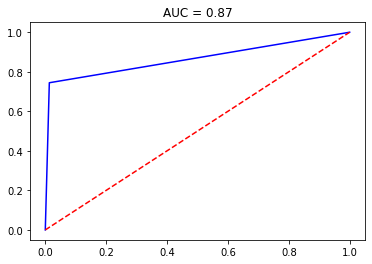

In [496]:
saca_metricas(y_test, y_pred_log_3)  

This model with more variables has worsened.

Feature: 0, Score: 0.08636
Feature: 1, Score: 0.03165
Feature: 2, Score: 0.00567
Feature: 3, Score: -0.04857
Feature: 4, Score: 2.40321
Feature: 5, Score: 1.34262
Feature: 6, Score: 0.03395
Feature: 7, Score: -0.00732
Feature: 8, Score: 0.03133
Feature: 9, Score: 0.01782
Feature: 10, Score: -0.01659
Feature: 11, Score: 0.00443
Feature: 12, Score: 0.03779
Feature: 13, Score: -0.00914
Feature: 14, Score: -1.93361
Feature: 15, Score: -0.69973
Feature: 16, Score: -5.40492
Feature: 17, Score: 0.11152
Feature: 18, Score: -0.59021
Feature: 19, Score: -0.09402
Feature: 20, Score: -0.09030
Feature: 21, Score: 0.00571
Feature: 22, Score: 0.05929
Feature: 23, Score: 0.05755
Feature: 24, Score: -0.01859
Feature: 25, Score: -0.01650
Feature: 26, Score: -0.04192
Feature: 27, Score: 0.02530
Feature: 28, Score: 0.04536
Feature: 29, Score: -0.07086


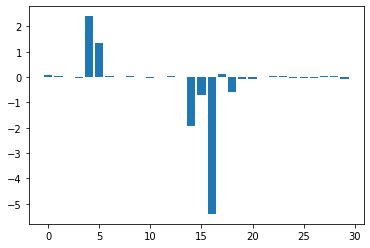

In [497]:
# get importance
importance = model_log_3.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

The most explanatory variables remain the same.

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17367   310]
 [    8  1409]]
accuracy
0.9833455535770399
precision
0.8196625945317044
recall
0.9943542695836274
f1
0.8985969387755102
AUC
0.9884086786058093


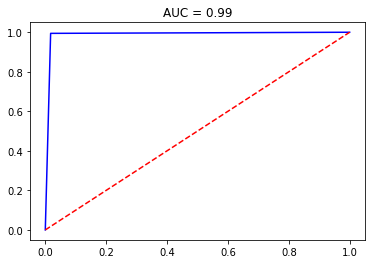

In [498]:
rf_classifier3 = RandomForestClassifier().fit(X_train, y_train)
y_pred3        = rf_classifier3.predict(X_test)
saca_metricas(y_test, y_pred3)

Feature: 0, Score: 0.01801
Feature: 1, Score: 0.02368
Feature: 2, Score: 0.01869
Feature: 3, Score: 0.00567
Feature: 4, Score: 0.23808
Feature: 5, Score: 0.28816
Feature: 6, Score: 0.02209
Feature: 7, Score: 0.01949
Feature: 8, Score: 0.02255
Feature: 9, Score: 0.02277
Feature: 10, Score: 0.02265
Feature: 11, Score: 0.00264
Feature: 12, Score: 0.01184
Feature: 13, Score: 0.00508
Feature: 14, Score: 0.01231
Feature: 15, Score: 0.01366
Feature: 16, Score: 0.09468
Feature: 17, Score: 0.01430
Feature: 18, Score: 0.12356
Feature: 19, Score: 0.00125
Feature: 20, Score: 0.00120
Feature: 21, Score: 0.00156
Feature: 22, Score: 0.00260
Feature: 23, Score: 0.00159
Feature: 24, Score: 0.00140
Feature: 25, Score: 0.00174
Feature: 26, Score: 0.00298
Feature: 27, Score: 0.00226
Feature: 28, Score: 0.00115
Feature: 29, Score: 0.00236


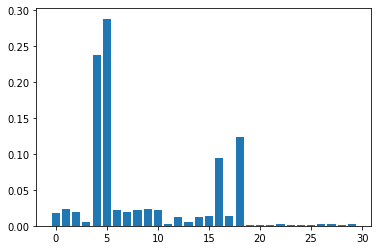

In [499]:
# Obtenemos la importancia de las variables 
importance = rf_classifier3.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

We do not find significant changes, but we see that the variables that are more explanatory remain the same. Added 'num_dt_nueva', but is related to 'num_dt'.

#### Summary so far:
We have not made an improvement through this process, since the explanatory variables remain the same.

#### Univariate analysis

In [500]:
target = y_december
features = list(december_data.columns)

x = december_data[features]
y = y_december

In [501]:
S_chi5 = SelectKBest(chi2, k = 5) #k = amount of variables that I want me to remove. it is chi2 because it is a regression model.
X_chi5 = S_chi5.fit_transform(x, y)

print ("List of variables ", np.asarray(list(x))[S_chi5.get_support()])

List of variables  ['num_dt' 'incidencia' 'imp_financ' 'descuentos' 'num_dt_nueva']


We observe that the variables selected through this method are the same ones that we chose previously according to the importance that we saw in the models.

In [502]:
important_var = december_data.copy(deep = True)
selec = ['num_dt', 'incidencia', 'descuentos','imp_financ'] #I do not select 'num_dt_nueva' since they have less correlation with our Y than 'num_dt'
important_var = important_var[selec]


In [503]:
important_var

,num_dt,incidencia,descuentos,imp_financ
id,,,,
1,0.0,0,0,0.000000
2,0.0,0,1,0.000000
3,0.0,0,1,0.000000
4,0.0,0,0,0.000000
5,2.0,0,0,0.000000
...,...,...,...,...
99995,0.0,0,0,23.138779
99996,0.0,0,0,0.000000
99997,0.0,0,0,14.616422


In [504]:
sc = StandardScaler()
important_var_Scaler = sc.fit_transform(important_var)

X_train, X_test, y_train, y_test = train_test_split(important_var_Scaler,
                                                    y_december,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_december)

In [505]:
#Modelo con todas las varibales
model_log_4 = LogisticRegression().fit(X_train, y_train)
y_pred_log_4 = model_log_4.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17398   279]
 [  200  1217]]
accuracy
0.9749135854195035
precision
0.8135026737967914
recall
0.8588567395906845
f1
0.8355647099210436
AUC
0.9215367592279384


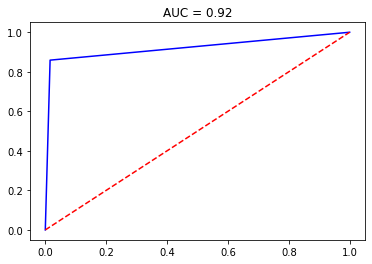

In [506]:
saca_metricas(y_test, y_pred_log_4)  

We can see that this model has almost the same metrics as the first, but with the difference that it has only 4 variables. In this sense we can say that it is much better.

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17364   313]
 [    8  1409]]
accuracy
0.9831884361579554
precision
0.8182346109175378
recall
0.9943542695836274
f1
0.8977381331634279
AUC
0.9883238225782028


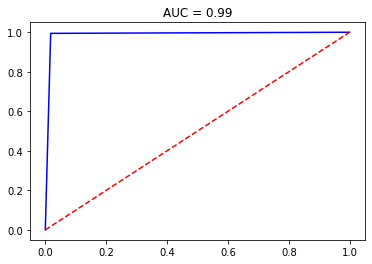

In [507]:
rf_classifier = RandomForestClassifier().fit(X_train, y_train)
y_pred       = rf_classifier.predict(X_test)
saca_metricas(y_test, y_pred)

We can see that this model has almost the same metrics as the previous ones, but with the difference that it has only 4 variables.
You have to take into account that it has a slightly lower precision, but personally I think that this model is the winner, since although I lose a little in that metric, I win in the reduction of parameters.

#### Cross validation

In [508]:
results = cross_val_score(estimator=rf_classifier, X=X_train, y=y_train, cv=5)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/o

In [509]:
results # all quite alike, that's good.

array([0.98527005, 0.98304419, 0.98527005, 0.98245384, 0.98284667])

In [510]:
print(results.mean())

0.9837769597448206


In [511]:
print(results.std())  

0.0012338285550918763


Finally I decide that the rf_classifier model is the best of all those made.

### 6) Prediction of January customers most likely to change operator in the following month.

We did the same data preprocessing that we did in December, but on the January data.

####  Missing values analysis (January)

In [512]:
january_data.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            90097
incidencia        90720
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      86045
imp_financ        86045
descuentos        72673
dtype: int64

In [513]:
january_data['num_dt'] = january_data['num_dt'].replace(np.nan, 0)

In [514]:
january_data['incidencia'] = january_data['incidencia'].replace(np.nan, 'NO')

In [515]:
january_data['financiacion'] = january_data['financiacion'].replace(np.nan, 'NO')

In [516]:
january_data['imp_financ'] = january_data['imp_financ'].replace(np.nan, 0)

In [517]:
january_data['descuentos'] = january_data['descuentos'].replace(np.nan, 0)

In [518]:
january_data.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
financiacion      0
imp_financ        0
descuentos        0
dtype: int64

#### --- Numerical variables Analysis--- (January)

In [519]:
january_data.dtypes 

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
financiacion       object
imp_financ        float64
descuentos         object
dtype: object

In [520]:
january_data.describe() 

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ
count,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000
mean,49997.623626,51.429237,207.488700,3.560214,0.071318,125.109836,49.858960,12510.190495,9985.382781,10030.443960,1.601433
std,28863.150364,19.585913,111.239476,1.085810,0.459214,72.421075,29.208549,7217.671483,5774.903324,5786.754197,6.366161
min,1.000000,18.000000,15.000439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24963.500000,34.000000,111.368385,3.000000,0.000000,62.000000,25.000000,6232.500000,4960.000000,5010.000000,0.000000
50%,49999.000000,51.000000,207.089366,4.000000,0.000000,125.000000,50.000000,12526.000000,9998.000000,10037.000000,0.000000
75%,74990.500000,68.000000,304.349361,4.000000,0.000000,188.000000,75.000000,18742.000000,14981.000000,15036.000000,0.000000
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.991954


In [521]:
january_data['id'].value_counts() 

2047     1
13011    1
725      1
6870     1
4823     1
        ..
21920    1
23969    1
17826    1
19875    1
2049     1
Name: id, Length: 92711, dtype: int64

#### --- non-numeric variables Analysis --- (January)

antiguedad, provincia, incidencia, conexion, vel_conexion, TV, financiacion, descuentos

1) ANTIGUEDAD

In [522]:
len(january_data['antiguedad'].unique())

92237

In [523]:
january_data['antiguedad'].value_counts() 

01/07/2020 03:55 PM    3
01/19/2020 04:57 PM    3
01/25/2020 12:51 PM    3
01/07/2020 10:37 PM    3
01/14/2020 05:08 PM    3
                      ..
01/05/2000 08:42 PM    1
09/08/2000 12:48 PM    1
08/15/2007 09:12 PM    1
10/26/2013 05:11 PM    1
12/03/2019 06:52 AM    1
Name: antiguedad, Length: 92237, dtype: int64

In [524]:
january_data['antiguedad'] = pd.to_datetime(january_data['antiguedad'])

In [525]:
january_data['año_ingreso'] = pd.DatetimeIndex(january_data['antiguedad']).year
january_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,año_ingreso
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,95,19,6525,7634,18520,FIBRA,50MB,tv-futbol,NO,0.0,0,2018
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,44,36,14471,14541,8016,FIBRA,600MB,tv-futbol,NO,0.0,SI,2017
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,94,27,1428,5248,7106,ADSL,35MB,tv-futbol,NO,0.0,SI,2001
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,186,20,20083,7372,5052,FIBRA,200MB,tv-familiar,NO,0.0,0,2015
4,6,51,99.348645,1997-11-04 11:43:00,Huelva,4,0.0,NO,37,32,19078,5009,8686,FIBRA,200MB,tv-futbol,NO,0.0,0,1997


In [526]:
january_data['antiguedad_años'] = 2020-january_data['año_ingreso']
january_data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,año_ingreso,antiguedad_años
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,95,19,...,7634,18520,FIBRA,50MB,tv-futbol,NO,0.0,0,2018,2
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,44,36,...,14541,8016,FIBRA,600MB,tv-futbol,NO,0.0,SI,2017,3
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,94,27,...,5248,7106,ADSL,35MB,tv-futbol,NO,0.0,SI,2001,19
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,186,20,...,7372,5052,FIBRA,200MB,tv-familiar,NO,0.0,0,2015,5
4,6,51,99.348645,1997-11-04 11:43:00,Huelva,4,0.0,NO,37,32,...,5009,8686,FIBRA,200MB,tv-futbol,NO,0.0,0,1997,23


In [527]:
january_data['antiguedad_años'].value_counts() 

0     4329
14    3650
21    3637
10    3595
16    3591
20    3588
13    3580
6     3575
12    3565
17    3565
9     3557
11    3556
23    3545
15    3537
2     3534
8     3524
25    3520
7     3510
18    3495
24    3488
19    3480
22    3475
1     3475
4     3474
5     3471
3     3395
Name: antiguedad_años, dtype: int64

In [528]:
january_data.drop('año_ingreso',axis=1, inplace=True)

In [529]:
january_data.drop('antiguedad',axis=1, inplace=True)

2) PROVINCIA

In [530]:
len(january_data['provincia'].unique())

50

In [531]:
january_data['provincia'].value_counts() 

Valencia                  1941
Asturias                  1934
Murcia                    1931
Navarra                   1930
Zaragoza                  1927
Málaga                    1924
Alicante                  1895
Orense                    1891
Guipúzcoa                 1886
Zamora                    1879
Huelva                    1878
Córdoba                   1875
Granada                   1874
Cáceres                   1868
La Coruña                 1867
Santa Cruz de Tenerife    1866
Burgos                    1866
Sevilla                   1865
Soria                     1865
Islas Baleares            1864
Almería                   1863
Cádiz                     1862
Álava                     1859
Tarragona                 1857
Badajoz                   1856
Castellón                 1854
Salamanca                 1854
Barcelona                 1852
Segovia                   1850
Valladolid                1850
Madrid                    1849
Ciudad Real               1848
Lugo    

In [532]:
january_data.provincia.replace(('Zaragoza','Navarra','Málaga','Asturias','Valencia',
                                   'Murcia','Orense','Alicante','Córdoba','Cáceres',
                                   'Burgos','Guipúzcoa','Álava','Valladolid','Sevilla',
                                   'Huelva', 'Santa Cruz de Tenerife', 'La Coruña', 'Segovia','Castellón',
                                   'Granada','Tarragona','Zamora','Almería','Soria',
                                   'Madrid','Pontevedra','Ciudad Real','Cádiz','Badajoz',
                                   'Islas Baleares','Barcelona','Teruel','Salamanca','Ávila',
                                   'Albacete','Jaén','Guadalajara','Lérida','La Rioja',
                                   'Lugo','Toledo','Gerona','Las Palmas','Palencia',
                                   'Cuenca','Cantabria','León','Vizcaya','Huesca'
                                   ),
                                  (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                  21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                                  38,39,40,41,42,43,44,45,46,47,48,49,50),inplace=True)

3) INCIDENCIA

In [533]:
january_data['incidencia'].value_counts()

NO    90720
SI     1991
Name: incidencia, dtype: int64

In [534]:
january_data['incidencia'] = january_data['incidencia'].map({'SI':1,'NO':0})

In [535]:
january_data['incidencia'].value_counts()

0    90720
1     1991
Name: incidencia, dtype: int64

4) CONEXIÓN

In [536]:
january_data['conexion'].value_counts()

ADSL     46591
FIBRA    46120
Name: conexion, dtype: int64

In [537]:
#ADSL = 1, FIBRA = 0
january_data['conexion'] = january_data['conexion'].map({'ADSL':1,'FIBRA':0})

In [538]:
january_data['conexion'].value_counts()

1    46591
0    46120
Name: conexion, dtype: int64

5) VELOCIDAD

In [539]:
january_data.vel_conexion = january_data.vel_conexion.map(dejar_solo_cifras)

In [540]:
january_data['vel_conexion'].value_counts()

200    9342
600    9300
300    9212
50     9167
100    9099
20     7882
25     7840
10     7807
30     7761
35     7674
15     7627
Name: vel_conexion, dtype: int64

In [541]:
january_data['vel_conexion'] = january_data['vel_conexion'].astype(int)

6) TV

In [542]:
january_data['TV'].value_counts()

tv-futbol      46191
tv-familiar    32822
tv-total       13698
Name: TV, dtype: int64

In [543]:
#tv-futbol:0, tv-familiar:1, tv-total:2
january_data['TV'] = january_data['TV'].map({'tv-futbol':0,'tv-familiar':1, 'tv-total':2})

In [544]:
january_data['TV'].value_counts()

0    46191
1    32822
2    13698
Name: TV, dtype: int64

7) FINANCIACIÓN

In [545]:
january_data['financiacion'].value_counts()

NO    86045
SI     6666
Name: financiacion, dtype: int64

In [546]:
january_data['financiacion'] = january_data['financiacion'].map({'SI':1,'NO':0})

In [547]:
january_data['financiacion'].value_counts()

0    86045
1     6666
Name: financiacion, dtype: int64

8) DESCUENTOS

In [548]:
january_data['descuentos'].value_counts()

0     72673
SI    20038
Name: descuentos, dtype: int64

In [549]:
january_data['descuentos'] = january_data['descuentos'].map({'SI':1,0:0})

In [550]:
january_data['descuentos'].value_counts()

0    72673
1    20038
Name: descuentos, dtype: int64

In [551]:
january_data.dtypes

id                   int64
edad                 int64
facturacion        float64
provincia            int64
num_lineas           int64
num_dt             float64
incidencia           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion             int64
vel_conexion         int64
TV                   int64
financiacion         int64
imp_financ         float64
descuentos           int64
antiguedad_años      int64
dtype: object

In [552]:
january_data.set_index('id',inplace=True)

In [553]:
#We select the same variables as in December
important_var_january = january_data.copy(deep = True)
important_var_january = important_var_january[selec]

In [554]:
#Escalamos los datos al igual que en diciembre
sc2 = StandardScaler()
january_data_Scaler = sc2.fit_transform(important_var_january)

In [555]:
january_data_Scaler

array([[-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529],
       ...,
       [-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529]])

In [556]:
january_data_Scaler = pd.DataFrame(january_data_Scaler)

In [557]:
january_data_Scaler

,0,1,2,3
0,-0.155306,-0.148144,-0.525098,-0.251555
1,-0.155306,-0.148144,1.904405,-0.251555
2,-0.155306,-0.148144,1.904405,-0.251555
3,-0.155306,-0.148144,-0.525098,-0.251555
4,-0.155306,-0.148144,-0.525098,-0.251555
...,...,...,...,...
92706,-0.155306,-0.148144,-0.525098,-0.251555
92707,-0.155306,-0.148144,-0.525098,2.044413
92708,-0.155306,-0.148144,-0.525098,-0.251555
92709,-0.155306,-0.148144,-0.525098,-0.251555


We save the winning model as a python object (pickle) and then use it again to predict future data.
In this case we use it to predict January, but it could be used for the following months.

In [558]:
pkl_filename = "modelo1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_classifier, file)

In [559]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [560]:
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 98.32 %


In [561]:
model_proba = rf_classifier.predict_proba(january_data_Scaler)[:,1]

In [562]:
model_proba = (pd.DataFrame(model_proba,columns=['probability'],index=january_data_Scaler.index))


In [563]:
model_proba.sort_values(by=['probability'],ascending=False,axis=0,inplace=True)

In [564]:
modelo_proba

NameError: name 'modelo_proba' is not defined

In [ ]:
model_proba['probability'].value_counts()

In [ ]:
#I want to sort it by probability, not by frequency, so I do this test.
test = pd.value_counts(model_proba['probability'])
test = pd.DataFrame(test)
test['Real_probability'] = test.index.values
test.sort_values(by = 'Real_probability',ascending = False)

### 7) Explanations

When I began to study this data set, I thought that some variables were going to weigh a lot (such as 'antiguedad') and that finally they did not.

As we can see, the variables that most explained our model were:
    - 'num_dt': number of defaults
    - 'incidencia': the client has an incident or not
    - 'imp_financ': amount financed
    - 'descuentos': the customer has or does not have an active discount

In [ ]:
#importance of the variables in the model

importance = rf_classifier.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
important_var_january.columns.values

From this information we can say that these 4 variables are the ones that mostly explain the change of operator for many clients between December 2019 and January 2020.

The variable that had the most weight in the model was 'num_dt', followed by 'incidence', 'discount' and finally 'imp_financ'.

In summary, this means customers who have some type of default and / or open incident with the company are more likely to churn. Customers who do not have any type of discount are more likely to change companies than those who have a discount.


#### Recommendations for the company:
- Based on what has been studied, we see that 1,556 clients have a probability greater than 50% of churning the company between January and February. That is why we recommend that, mainly to these clients, you send them the loyalty campaign, and if necessary offer them a discount, since this reduces the probability of canceling the contracted service.
- It is also recommended that, mainly with these users, see if they have an incidence and if so, find a way to solve them.